# Create and run a local RAG pipeline from scratch

## What is RAG?

RAG stands for Retrieval Augmented Generation.

The goal of RAG is to take information and pass it to an LLM so it can generate outputs based on that information.

* Retrieval - Find relevant information given a query, e.g. "what are the macronutrients and what do they do?" -> retrieves passages of text related to the macronutrients from a nutrition textbook.
* Augmented - We want to take the relevant information and augment our input (prompt) to an LLM with that relevant information.
* Generation - Take the first two steps and pass them to an LLM for generative outputs.

If you want to read where RAG came from, see the paper from Facebook AI: https://arxiv.org/abs/2005.11401

> This work offers several positive societal benefits over previous work: the fact that it is more
strongly grounded in real factual knowledge (in this case Wikipedia) makes it “hallucinate” less
with generations that are more factual, and offers more control and interpretability. RAG could be
employed in a wide variety of scenarios with direct benefit to society, for example by endowing it
with a medical index and asking it open-domain questions on that topic, or by helping people be more
effective at their jobs.

## Why RAG?

The main goal of RAGs is to improve the generation of LLMs.

1. Prevent hallucinations - LLMs are incredible at generating *good-looking* text. However, this text doesn't mean that it's factual. RAG can help LLMs generate information based on relevant passages that are factual.
2. Work with custom data - Many LLMs are trained with internet-scale data. This means they have a fairly good understanding of language in general. However, it also does a lot of their response can be generic in nature. RAG helps to create specific documents (e.g. your own companies customer support documents).

## What can RAG be used for?

* Customer support Q&A chat - Treat your existing customer support documents as a resource and when a customer asks a question, you could have a retrieve system, relevant documentation snippets and then have an LLM craft those snippets into an answer. Think of this as a "chatbot for your documentation".
* Email chain analysis - Let's say you're a large insurance company, and you have chains of emails of customer claims. You can use a RAG pipeline to find relevant information from those emails and then use an LLM to process that information into structured data.
* Company internal documentation chat
* Textbook Q&A - Let's say you're a nutrition student and you've got a 1200-page textbook read, you could build a RAG pipeline to go through the textbook and find relevant passages to the questions you have

Common theme here: take your relevant documents to a query and process them with an LLM.

From this angle, you can consider an LLM as a calculator for words.

## Why Local?

Fun :D

Privacy, speed, and cost.

* Privacy - If you have private documentation, maybe you don't want to send that to an API. You want to set up an LLM and run it on your own hardware.
* Speed - Whenever you use an API, you have to send some kind of data across the internet. This takes time. Running locally means we don't have to wait to transfer of data.
* Cost - If you own your hardware, the cost is paid. It may have a large cost to begin with. But overtime, you don't have to keep paying API fees.
* No vendor lock in - If you run your own software/hardware. If OpenAI/another Large internet company shut do tomorrow, you can still run you business

## What we're going to build

* https://github.com/mrdbourke/simple-local-rag
* https://whimsical.com/simple-local-rag-workflow-39kToR3yNf7E8kY4sS2tjV

## What we're going to build

* https://github.com/mrdbourke/simple-local-rag
* https://whimsical.com/simple-local-rag-workflow-39kToR3yNf7E8kY4sS2tjV

We're going to build NutriChat to "chat with a nutrition textbook".

Specifically:

1. Open a PDF document (you could use almost any PDF here or even a collection of PDFs).
2. Format the text of the PDF textbook ready for an embedding model.
3. Embed all of the chunks of text in the textbook and turn them into numerical reprentations (embedding) which can store for later.
4. Build a retrieval system that uses vector search to find relevant chunk of text based on a query.
5. Create a prompt that incorporates the retrieved pieces of text.
6. Generate an answer to a query based on the passages of the textbook with an LLM.

All locally!

1. Steps 1-3: Document preprocessing and embedding creation.
2. Steps 4-6: Search and answer.

## 1. Document/text processing and embedding creation

Ingredients:
* PDF document of choice (note: this could be almost any kind of document, I've just chosen to focus on PDFs for now).
* Embedding model of choice.

Steps:
1. Import PDF document.
2. Process text for embedding (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later (embeddings will store on file for many years or until you lose your hard drive).

### Import PDF Document

In [1]:
import os

import pandas as pd
import requests
from dask.array import indices
from distributed.dashboard.components.nvml import gpu_memory_doc
from sentence_transformers.util import dot_score
from torch.nn.functional import embedding
from torch.onnx.symbolic_opset9 import embedding

# Get PDF document path
pdf_path = "human-nutrition-text.pdf"

# Download PDF
if not os.path.exists(pdf_path):
    print(f"[INFO] Downloading {pdf_path}...")

    # Enter the URL of the PDF
    url="https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    # Send a GET request
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Open the file and save it
        with open(pdf_path, 'wb') as f:
            f.write(response.content)
        print(f"[INFO] The file has been downloaded and saved as {pdf_path}...")
    else:
        print(f"[ERROR] Failed to download {response.status_code}...")
else:
    print(f"[INFO] {pdf_path} exists...")

[INFO] human-nutrition-text.pdf exists...


We've got the PDF let's format it

In [2]:
import fitz
from tqdm.auto import tqdm

def text_formater(text: str) -> str:
    """
    Performs minor formatting on text
    :param text:
    :return:
    """
    cleaned_text = text.replace("\n", " ").strip()

    # Potentially more text formatting functions can go here
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formater(text)
        pages_and_texts.append({
            "page_number": page_number-41,
            "page_char_count": len(text),
            "page_word_count": len(text.split(" ")),
            "page_sentence_count_raw": len(text.split(". ")),
            "page_token_count": len(text) / 4, # 1 token = ~4 charecters
            "text": text
        })
    return pages_and_texts
pages_and_text = open_and_read_pdf(pdf_path)
pages_and_text[:5]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''},
 {'page_number': -39,
  'page_char_count': 320,
  'page_word_count': 54,
  'page_sentence_count_raw': 1,
  'page_token_count': 80.0,
  'text': 'Human Nutrition: 2020  Edition  UNIVERSITY OF HAWAI‘I AT MĀNOA  FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM  ALAN TITCHENAL, SKYLAR HARA,  NOEMI ARCEO CAACBAY, WILLIAM  MEINKE-LAU, YA-YUN YANG, MARIE  KAINOA FIALKOWSKI REVILLA,  JENNIFER DRAPER, GEMADY  LANGFELDER, CHERYL GIBBY, CHYNA  NICOLE CHUN, AND ALLISON  CALABRESE'},
 {'page_number': -38,
  'page_char_count': 212,
  'page_word_count': 32,
  'page_sentence_count_raw': 1,
  'page_token_count': 53.0,
  'text': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food 

In [3]:
import random
random.seed(42)
random.sample(pages_and_text, k=5)

[{'page_number': 187,
  'page_char_count': 1528,
  'page_word_count': 255,
  'page_sentence_count_raw': 1,
  'page_token_count': 382.0,
  'text': 'Seasoning  Foods  Allspice  Lean ground meats, stews, tomatoes, peaches, applesauce,  cranberry sauce, gravies, lean meat  Almond  extract  Puddings, fruits  Caraway  seeds  Lean meats, stews, soups, salads, breads, cabbage,  asparagus, noodles  Chives  Salads, sauces, soups, lean-meat dishes, vegetables  Cider  vinegar  Salads, vegetables, sauces  Cinnamon  Fruits, breads, pie crusts  Curry  powder  Lean meats (especially lamb), veal, chicken, fish, tomatoes,  tomato soup, mayonnaise,  Dill  fish sauces, soups, tomatoes, cabbages, carrots,  cauliflower, green beans, cucumbers, potatoes, salads,  macaroni, lamb  Garlic (not  garlic salt)  Lean meats, fish, soups, salads, vegetables, tomatoes,  potatoes  Ginger  Chicken, fruits  Lemon  juice  Lean meats, fish, poultry, salads, vegetables  Mace  Hot breads, apples, fruit salads, carrots, cauli

In [4]:
import pandas as pd

df = pd.DataFrame(pages_and_text)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [5]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00
std,348.86,560.38,95.76,6.19,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,4.00,190.50
50%,562.50,1231.50,214.50,10.00,307.88
75%,864.25,1603.50,271.00,14.00,400.88
max,1166.00,2308.00,429.00,32.00,577.00


Why would we care about token count?

Token count is important to think about because:
1. Embedding models don't deal with infinite tokens.
2. LLMs don't deal with infinite tokens.

For example an embedding model may have been trained to embed sequences of 384 tokens into numerical space (sentence-transformers `all-mpnet-base-v2`, see: https://www.sbert.net/docs/pretrained_models.html).

As for LLMs, they can't accept infinite tokens in their context window, plus it would be cost ineffective to send 100,000s of tokens to an LLM every time.

We want the tokens we send to an LLM to valuable tokens.

### Further text processing (splitting pages into sentences)

Two ways to do this:
1. We've done this by splitting on `". "`.
2. We can do this with a NLP library such as spaCy (https://spacy.io/usage) and nltk (https://www.nltk.org/).

In [6]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer
nlp.add_pipe("sentencizer")

# Create document instance as an example
doc = nlp("This is a sentence. This another sentence. I like elephants.")
assert len(list(doc.sents)) == 3

# Print out our sentences split
list(doc.sents)

[This is a sentence., This another sentence., I like elephants.]

In [7]:
for item in tqdm(pages_and_text):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings (the default type is spaCy datatype
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [8]:
random.sample(pages_and_text, k=2)

[{'page_number': 244,
  'page_char_count': 1413,
  'page_word_count': 251,
  'page_sentence_count_raw': 13,
  'page_token_count': 353.25,
  'text': 'your body senses blood glucose levels and maintains the glucose  “temperature” in the target range. The glucose thermostat is located  within the cells of the pancreas. After eating a meal containing  carbohydrates glucose levels rise in the blood.  Insulin-secreting cells in the pancreas sense the increase in blood  glucose and release the hormone, insulin, into the blood. Insulin  sends a signal to the body’s cells to remove glucose from the blood  by transporting it into different organ cells around the body and  using it to make energy. In the case of muscle tissue and the liver,  insulin sends the biological message to store glucose away as  glycogen. The presence of insulin in the blood signifies to the body  that glucose is available for fuel. As glucose is transported into the  cells around the body, the blood glucose levels decrea

In [9]:
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32
std,348.86,560.38,95.76,6.19,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


### Chunking our sentences together

The concept of splitting larger pieces of text into smaller ones is often referred to as text splitting or chunking.

There is no 100% correct way to do this.

We'll keep it simple and split into groups of 10 sentences (however, you could also try 5, 7, 8, whatever you like).

There are frameworks such as LangChain which can help with this, however, we'll stick with Python for now: https://python.langchain.com/docs/modules/data_connection/document_transformers/

Why we do this:
1. So our texts are easier to filter (smaller groups of text can be easier to inspect that large passages of text).
2. So our text chunks can fit into our embedding model context window (e.g. 384 tokens as a limit).
3. So our contexts passed to an LLM can be more specific and focused.

In [10]:
# Define split size to turn group of sentences into chunks
num_sentences_chunk_size = 10

# Create a function to split lists of texts recursively into chunk size
# e.g. [20] -> [10, 10] or [25] -> [10, 10, 5]
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    return [input_list[i:i+ slice_size] for i in range(0, len(input_list), slice_size)]
test_list = list(range(25))
split_list(test_list, num_sentences_chunk_size)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [11]:
# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_text):
    item["sentences_chunks"] = split_list(input_list=item["sentences"],
                                          slice_size=num_sentences_chunk_size)
    item["num_chunks"] = len(item["sentences_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [12]:
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32,1.53
std,348.86,560.38,95.76,6.19,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00,1.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00,1.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

That'll give us a good level of granularity.

Meaning, we can dive specifically into the text sample that was used in our model.

In [13]:
import re # Regex

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_text):
    for sentence_chunk in item["sentences_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka join the list of sentences into one paragraph
        joined_sentence_chunks = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunks = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunks)

        chunk_dict["sentence_chunk"] = joined_sentence_chunks
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunks)
        chunk_dict["chunk_word_count"] = len(joined_sentence_chunks.split(" "))
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunks) / 4 # 1 token = ~4 chars

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [14]:
random.sample(pages_and_chunks, k=2)

[{'page_number': 892,
  'sentence_chunk': 'Micronutrients Micronutrient recommendations for adolescents are mostly the same as for adults, though children this age need more of certain minerals to promote bone growth (e.g., calcium and phosphorus, along with iron and zinc for girls). Again, vitamins and minerals should be obtained from food first, with supplementation for certain micronutrients only (such as iron). The most important micronutrients for adolescents are calcium, vitamin D, vitamin A, and iron. Adequate calcium and vitamin D are essential for building bone mass. The recommendation for calcium is 1,300 milligrams for both boys and girls. Low-fat milk and cheeses are excellent sources of calcium and help young people avoid saturated fat and cholesterol. It can also be helpful for adolescents to consume products fortified with calcium, such as breakfast cereals and orange juice. Iron supports the growth of muscle and lean body mass. Adolescent girls also need to ensure suffi

In [15]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.44,112.33,183.61
std,347.79,447.54,71.22,111.89
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,44.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


In [16]:
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-41,Human Nutrition: 2020 Edition,29,4,7.25
1,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00
2,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50
3,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50
4,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25


### Filter chunks of text for short chunks

These chunks may not contain much useful information.

In [17]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 21.75 | Text: Advanced nutrition and human metabolism. Boston, MA: Cengage Learning. Molybdenum | 693
Chunk token count: 16.0 | Text: Accessed January 20, 2018. The Effect of New Technologies | 1031
Chunk token count: 9.5 | Text: 742 | Building Healthy Eating Patterns
Chunk token count: 27.75 | Text: https://jamanetwork.com/journals/jama/ fullarticle/195531. Accessed October 5, 2017. 538 | Fat-Soluble Vitamins
Chunk token count: 18.0 | Text: Updated July 24, 2017. Accessed April 15, 2018. 1112 | Threats to Health


In [18]:
# Filter our DataFrame for rows with under 30 tokens

pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [19]:
random.sample(pages_and_chunks_over_min_token_len, k=2)

[{'page_number': 794,
  'sentence_chunk': 'For pregnant women, the RDA of nearly all vitamins and minerals increases. Table 13.2 Recommended Nutrient Intakes during Pregnancy 794 | Pregnancy',
  'chunk_char_count': 147,
  'chunk_word_count': 22,
  'chunk_token_count': 36.75},
 {'page_number': 103,
  'sentence_chunk': 'Bronchioles lead to alveolar sacs in the respiratory zone, where gas exchange occurs. Gross Anatomy of the Lungs The lungs are pyramid-shaped, paired organs that are connected to the trachea by the right and left bronchi; below the lungs is the diaphragm, a flat, dome-shaped muscle located at the base of the lungs and thoracic cavity. Figure 2.18 Basic Anatomy of the Lungs \xa0 Each lung is composed of smaller units called lobes. Fissures separate these lobes from each other. The right lung consists of three lobes: the superior, middle, and inferior lobes. The left lung consists of two lobes: the superior and inferior lobes. Blood Supply The major function of the lungs is

### Embedding our text chunks

Embeddings are a broad but powerful concept.

While humans understand text, machines understand numbers.

What we'd like to do:
- Turn our text chunks into numbers, specifically embeddings.

A useful numerical representation.

The best part about embeddings is that are a *learned* representation.

```
{"the": 0,
"a": 1,
...
```

For a great resource on learning embeddings, see here: https://vickiboykis.com/what_are_embeddings/

In [20]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="mps")

# Create a list of sentences
sentences = ["The Sentence Transformer library provides an easy way to create embeddings.",
             "Sentences can be embedded one by one or in a list.",
             "I like horses!"]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")

Sentence: The Sentence Transformer library provides an easy way to create embeddings.
Embedding: [-3.44285667e-02  2.95328610e-02 -2.33643148e-02  5.57257459e-02
 -2.19098218e-02 -6.47062296e-03  1.02850022e-02 -6.57804310e-02
  2.29718424e-02 -2.61120573e-02  3.80421393e-02  5.61402589e-02
 -3.68747078e-02  1.52788656e-02  4.37021069e-02 -5.19723371e-02
  4.89479415e-02  3.58108082e-03 -1.29750641e-02  3.54384654e-03
  4.23262082e-02  3.52606662e-02  2.49401890e-02  2.99177412e-02
 -1.99381579e-02 -2.39752512e-02 -3.33373668e-03 -4.30449806e-02
  5.72014041e-02 -1.32517386e-02 -3.54478061e-02 -1.13936001e-02
  5.55561222e-02  3.61099746e-03  8.88527666e-07  1.14027206e-02
 -3.82230245e-02 -2.43549864e-03  1.51313953e-02 -1.32617657e-04
  5.00658937e-02 -5.50876930e-02  1.73444115e-02  5.00958711e-02
 -3.75959873e-02 -1.04463510e-02  5.08322865e-02  1.24861076e-02
  8.67376849e-02  4.64143492e-02 -2.10689921e-02 -3.90251614e-02
  1.99694885e-03 -1.42345764e-02 -1.86795089e-02  2.826693

In [21]:
embeddings[0].shape

(768,)

In [22]:
embedding = embedding_model.encode("My favourite speciality is ML")
embedding

array([-3.44621353e-02,  3.63888144e-02, -6.99324086e-02, -7.11216964e-03,
        3.76917142e-03,  2.76853871e-02, -7.79493107e-03, -1.10859899e-02,
        1.14853578e-02,  1.25137847e-02,  5.08331619e-02,  3.00617628e-02,
       -4.38568592e-02,  7.80650824e-02,  3.32335569e-02, -6.20318651e-02,
        1.50678982e-03, -2.91338116e-02, -4.00031507e-02, -3.47931683e-02,
       -3.95171680e-02,  4.21969657e-04, -3.74178365e-02,  8.46347492e-03,
        2.55109183e-02, -1.96385738e-02,  4.91207018e-02, -6.22952655e-02,
        1.50213633e-02,  8.22385326e-02,  1.00987765e-03, -4.17508855e-02,
        4.72773844e-03,  6.30068928e-02,  1.40281293e-06, -3.80567983e-02,
       -2.46520508e-02,  3.65274139e-02, -2.20363308e-02, -2.25956999e-02,
        1.11154830e-02,  2.86698854e-03,  2.45557334e-02,  8.34757928e-03,
       -5.65574616e-02,  7.07871988e-02,  5.54012097e-02, -4.58004810e-02,
       -4.54237163e-02,  1.54766832e-02,  4.78206947e-03, -4.91500013e-02,
        3.09513509e-02, -

In [ ]:
%%time

# embedding_model.to("cpu")

# Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

In [24]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

CPU times: user 609 μs, sys: 5.2 ms, total: 5.8 ms
Wall time: 46.4 ms


'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to their fascinating food creations. Add

In [25]:
len(text_chunks)

1680

In [26]:
# %%time
#
# # Embed all texts in batches
# text_chunk_embeddings = embedding_model.encode(text_chunks,
#                                                batch_size=32, # you can experiment to find which batch size leads to best results
#                                                convert_to_tensor=True)
# text_chunk_embeddings

KeyboardInterrupt: 

### Save embedding to file

In [27]:
pages_and_chunks_over_min_token_len[419]

{'page_number': 277,
 'sentence_chunk': 'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture 

In [28]:
# Save embeddings to file
text_chunk_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunk_and_embeddings_df.csv"
text_chunk_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [29]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242750e-02 9.02281925e-02 -5.09549724e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156046e-02 5.92139848e-02 -1.66167170e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801767e-02 3.39813977e-02 -2.06426550e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566985e-02 3.81274931e-02 -8.46853480e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264531e-02 -8.49767402e-03 9.57159512e-...


If your embedding database is really large (e.g. over 100k-1M samples) you might want to look into using a vector database for storage: https://en.wikipedia.org/wiki/Vector_database

## 2. RAG - Search and Answer

RAG goal: Retrieve relevant passages based on a query and use those passages to augment an input to an LLM so it can generate an output based on those relevant passages.

### Similarity search

Embeddings can be used for almost any type of data.

For example, you can turn images into embeddings, sound into embeddings, text into embeddings, etc...

Comparing embeddings is known as similarity search, vector search, semantic search.

In our case, we want to query our nutrition textbook passages based on semantics or *vibe*.

So if I search for "macronutrients functions" I should get relevant passages to that text, but may not contain exactly the words "macronutrient functions".

Where as with keyword search, if I search "apple" I get back passages with specifically "apple".

In [44]:
import random

import torch
import numpy as np
import pandas as pd

device = "mps" if torch.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")

# Import texts and embedding df
text_chunk_and_embedding_df = pd.read_csv("text_chunk_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it saved to CSV
text_chunk_and_embedding_df["embedding"] = text_chunk_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert our embeddings into a torch.Tensor
embeddings = torch.tensor(np.stack(text_chunk_and_embedding_df["embedding"].tolist(), axis=0),dtype=torch.float32, device=device)

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunk_and_embedding_df.to_dict(orient="records")

text_chunk_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.067424275, 0.0902281925, -0.00509549724, -0..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156046, 0.0592139848, -0.016616717, -0...."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801767, 0.0339813977, -0.020642655, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.0682566985, 0.0381274931, -0.0084685348, -0..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264531, -0.00849767402, 0.00957159512, ..."


In [45]:
embeddings.shape

torch.Size([1680, 768])

In [46]:
# Create a model
from sentence_transformers import SentenceTransformer, util

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)

Embedding model ready!

Let's create a small semantic search pipeline.

In essence, we want to search for a query (e.g. "macronutrient functions") and get back relevant passages from our textbook.

We can do so with the following steps:
1. Define a query string.
2. Turn the query string into an embedding.
3. Perform a dot product or cosine similarity function between the text embeddings and the query embedding.
4. Sort the results from 3 in descending order.

In [48]:
# 1. Define the query
query = "macronutrients functions"
print(f"Query: {query}")

# 2. Embed the query
# Note: it's important to embed your query with the same model you embedded your passages with
query_embedding = embedding_model.encode(query.strip(), convert_to_tensor=True).to(device)

# 3. Get similarity scores with the dot product (use cosine similarity if outputs of the model aren't normalized)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(query_embedding, embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time: 5f} seconds.")

# 4. Get the top-k results (we'll keep top 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
[INFO] Time taken to get scores on 1680 embeddings:  0.011378 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='mps:0'),
indices=tensor([42, 47, 41, 51, 46], device='mps:0'))

In [50]:
large_embeddings = torch.randn(100*embeddings.shape[0], embeddings.shape[1], device=device)
print(f"Embeddings shape: {large_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(query_embedding, large_embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(large_embeddings)} embeddings: {end_time-start_time: 5f} seconds.")

Embeddings shape: torch.Size([168000, 768])
[INFO] Time taken to get scores on 168000 embeddings:  0.096477 seconds.


We can see that searching over embeddings is very fast even if we do exhaustive.

But if you had 10M+ embeddings, you likely want to create an index.

An index is like letters in the dictionary.

For example, if you wanted to search "duck" in the dictionary, you'd start at "d" then find words close to "du..." etc.

An index helps to narrow it down.

A populary indexing library for vector search is Faiss, see here: https://github.com/facebookresearch/faiss

One technique that the library provides is approximate nearest neighbour search (ANN): https://en.wikipedia.org/wiki/Nearest_neighbor_search

Let's make our vector search results pretty.

In [60]:
import textwrap

def print_wrapped(text, wrap_length=80):
    print(textwrap.fill(text, wrap_length))

In [61]:
print(f"Query: '{query}'\n")
print("Results:")

# Loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")
    # print_wrapped(query)

Query: 'macronutrients functions'

Results:
Score: 0.6926
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are 

Note: We could potentially improve the order of these results with a reranking model. A model that has been trained specifically to take search results (e.g. the top 25 semantic results) and rank them in order from most likely top-1 to least likely.

See here for an open-source reranking model: https://huggingface.co/mixedbread-ai/mxbai-rerank-large-v1

To check our results, what if we wanted to automatically surface the page of texts related to our query?

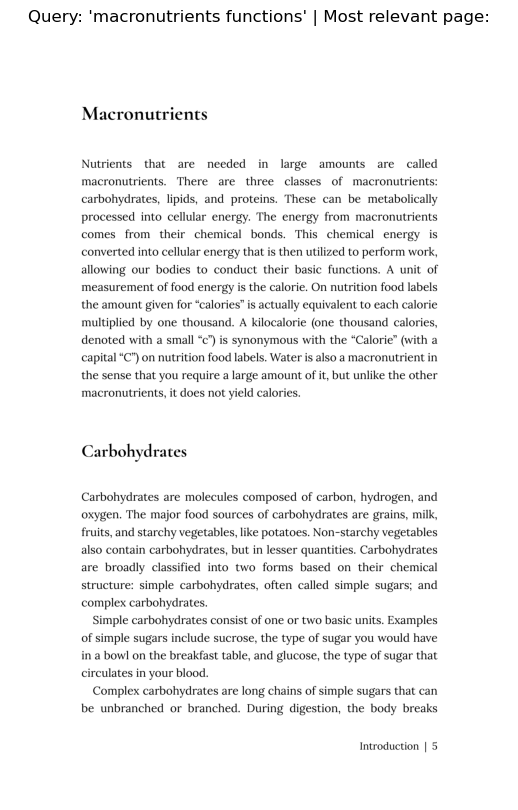

In [69]:
import fitz

# open PDF and load target
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(pages_and_chunks[top_results_dot_product[1][0]]['page_number'] + 41) # note page numbers of our PDF strt 41+

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Save image (optional)
doc.close()

# Convert the pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis("off")
plt.show()

### Similarity measures: dot product and cosine similarity

Two of the most common similarity measures between vectors are dot product and cosine similarity.

In essence, closer vectors will have higher scores, further away vectors will have lower scores.

Vectors have direction (which way is it going?) and magnitude (how long is it?).

Measures between vectors.

Specifically, embedding vectors which are representations of data with magnitude and direction in high dimensional space (our embedding vectors have 768 dimensions).

Two of the most common you'll across are the dot product and cosine similarity.

They are quite similar.

The main difference is that cosine similarity has a normalization step.

| Similarity measure | Description | Code |
| ----- | ----- | ----- |
| [Dot Product](https://en.wikipedia.org/wiki/Dot_product) | - Measure of magnitude and direction between two vectors<br>- Vectors that are aligned in direction and magnitude have a higher positive value<br>- Vectors that are opposite in direction and magnitude have a higher negative value | [`torch.dot`](https://pytorch.org/docs/stable/generated/torch.dot.html), [`np.dot`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html), [`sentence_transformers.util.dot_score`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.dot_score) |
| [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) | - Vectors get normalized by magnitude/[Euclidean norm](https://en.wikipedia.org/wiki/Norm_(mathematics))/L2 norm so they have unit length and are compared more so on direction<br>- Vectors that are aligned in direction have a value close to 1<br>- Vectors that are opposite in direction have a value close to -1 | [`torch.nn.functional.cosine_similarity`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html), [`1 - scipy.spatial.distance.cosine`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html) (subtract the distance from 1 for similarity measure), [`sentence_transformers.util.cos_sim`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.cos_sim) |

For text similarity, you generally want to use cosine similarity as you are after the semantic measurements (direction) rather than magnitude.

In our case, our embedding model `all-mpnet-base-v2` outputs normalized outputs (see the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#usage-huggingface-transformers) for more on this) so dot product and cosine similarity return the same results. However, dot product is faster due to not need to perform a normalize step.

To make things bit more concrete, let's make simple dot product and cosine similarity functions and view their results on different vectors.

> **Note:** Similarity measures between vectors and embeddings can be used on any kind of embeddings, not just text embeddings. For example, you could measure image embedding similarity or audio embedding similarity. Or with text and image models like [CLIP](https://github.com/mlfoundations/open_clip), you can measure the similarity between text and image embeddings.

In [74]:
def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L1 norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example vectors/tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)
vector5 = torch.tensor([-40000, 0, 60000], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))
print("Dot product between vector1 and vector5:", dot_product(vector1, vector5))

# Cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))
print("Cosine similarity between vector1 and vector5:", cosine_similarity(vector1, vector5))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Dot product between vector1 and vector5: tensor(140000.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)
Cosine similarity between vector1 and vector5: tensor(0.5189)


#### Notes:
Notice for both dot product and cosine similarity the comparisons of `vector1` and `vector2` are the opposite of `vector1` and `vector4`.

Comparing `vector1` and `vector2` both equations return positive values (14 for dot product and 1.0 for cosine similarity).

But comparing `vector1` and `vector4` the result is in the negative direction.

This makes sense because `vector4` is the negative version of `vector1`.

Whereas comparing `vector1` and `vector3` shows a different outcome.

For the dot product, the value is positive and larger then the comparison of two exactly the same vectors (32 vs 14).

However, for the cosine similarity, thanks to the normalization step, comparing `vector1` and `vector3` results in a postive value close to 1 but not exactly 1.

It is because of this that when comparing text embeddings, cosine similarity is generally favoured as it measures the difference in direction of a pair of vectors rather than difference in magnitude.

And it is this difference in direction that is more generally considered to capture the semantic meaning/vibe of the text.

The good news is that as mentioned before, the outputs of our embedding model `all-mpnet-base-v2` are already normalized.

So we can continue using the dot product (cosine similarity is dot product + normalization).

With similarity measures explained, let's functionize our semantic search steps from above so we can repeat them.

### Functionizing our semantic search pipeline

Let's put all the steps from above for semantic search into a function or two so we can repeat the workflow.

In [77]:
def retrive_relevant_recources(query: str,
                               embeddings: torch.Tensor,
                               model: SentenceTransformer=embedding_model,
                               n_resources_to_return: int=5,
                               print_time: bool = True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    :param query: The query to embed.
    :param embeddings: The embeddings to use.
    :param model: The model to use.
    :param n_resources_to_return:  The number of resources to return.
    :param print_time:
    :return:
    """
    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True).to(device)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(query_embedding)} embeddings: {end_time-start_time: 5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.Tensor,
                                 pages_and_chunks= pages_and_chunks,
                                 n_resources_to_return: int = 5):
    """
    Finds relevant recources and returns top scores and indices from embeddings.
    :param query:
    :param embeddings:
    :param pages_and_chunks:
    :param n_resources_to_return:
    :return:
    """
    scores, indices = retrive_relevant_recources(query=query,
                                                 embeddings=embeddings,
                                                 model=embedding_model,
                                                 n_resources_to_return= n_resources_to_return)
    # Loop through zipped together scores and indices from torch.topk
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")

In [79]:
print_top_results_and_scores(query="Foods high in fiber", embeddings=embeddings)

[INFO] Time taken to get scores on 768 embeddings:  0.026300 seconds.
Score: 0.6964
Text:
• Change it up a bit and experience the taste and satisfaction of other whole
grains such as barley, quinoa, and bulgur. • Eat snacks high in fiber, such as
almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green
peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
Page number: 276


Score: 0.6810
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a
few dietary sources of them are whole-grain foods, flax, cauliflower, and
avocados. Cellulose is the most abundant fiber in plants, making up the cell
walls and providing structure. Soluble fibers are more easily accessible to
bacterial enzymes in the large intestine so they can be broken down to a greater
extent tha

### Getting an LLM for local generation

We want to focus on local genertion.

However, this process will also work with an LLM API.

What is a generative LLM?

Goes from text input -> generate text output.

Which LLM should I use?

* How much hardware VRAM do you have available?

### Checking our local GPU memory availability

In [123]:
import torch
gpu_memory_bytes = torch.mps.recommended_max_memory()
gpu_memory_bytes

5.333343505859375